# Perform Attribute Prediction Task on CelebA

## Preparing Data

In [3]:
from pathlib import Path
data_path = Path("data/")
data_path.mkdir(exist_ok=True,parents=True)
if (data_path / "img_align_celeba").exists():
    print("File already exists")
else:
    print("Extracting file...")
    !mv "img_align_celeba.zip" "data/img_align_celeba.zip"
    !mv "list_attr_celeba.txt" "data/list_attr_celeba.csv"
    !unzip -q "data/img_align_celeba.zip" -d data/
    print("Done!")

File already exists


In [4]:
# removing first line from text file
new_lines = []
with open(data_path / "list_attr_celeba.txt", "r") as f:
    print("reading file")
    lines = f.readlines()
    for line in lines[1:]:
        line = line.split()
        new_lines.append(';'.join(line).replace('-1','0')+'\n')
# creating new csv file
print("writing file as csv")
with open(data_path / "list_attr_celeba.csv", "w") as f:
    f.writelines(new_lines)
print("Done!")

reading file
writing file as csv
Done!


In [5]:
import pandas as pd
df = pd.read_csv(data_path / "list_attr_celeba.csv", sep=';')
df.reset_index(inplace=True)

In [6]:
df.head()

,index,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## Defining pytorch dataset class

In [7]:
# Defining pytorch dataset class
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
from skimage import io

class CelebADataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file, sep=';')
        self.annotations.reset_index(inplace=True)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        # print(self.root_dir, self.annotations.iloc[index, 0])
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        # print(f"img_path: {img_path}")
        # changing [h,w,c] to [c,h,w]
        image = io.imread(img_path).transpose((2,0,1)).astype('float32')/255
        y_label = torch.tensor(self.annotations.iloc[index, -9:-1], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [8]:
# testing dataset class
dataset = CelebADataset(csv_file=data_path / "list_attr_celeba.csv", root_dir=data_path / "img_align_celeba")

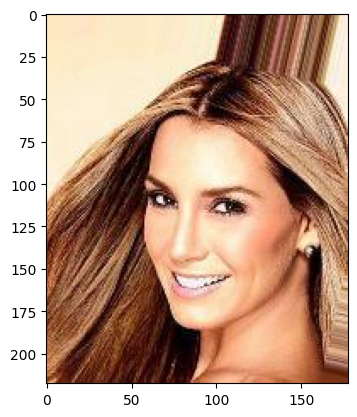

In [9]:
from matplotlib import pyplot as plt
plt.imshow(dataset[0][0].transpose((1,2,0)))
plt.show()

In [10]:
dataset[0][1]

tensor([1., 1., 0., 1., 0., 1., 0., 0.])

## Creating train and test dataset

In [11]:
# Creating train and test dataset
length = len(dataset)
train_size = int(0.8 * length)
test_size = length - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(f"length: {length}, train_size: {train_size}, test_size: {test_size}")
print(f"train_dataset: {len(train_dataset)}, test_dataset: {len(test_dataset)}")

length: 202599, train_size: 162079, test_size: 40520
train_dataset: 162079, test_dataset: 40520


## Creating Dataloaders

In [12]:
BATCH_SIZE = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
print(f"len(train_dataloader): {len(train_dataloader)}, len(test_dataloader): {len(test_dataloader)}")

len(train_dataloader): 1267, len(test_dataloader): 317


In [13]:
next(iter(train_dataloader))[0].shape, next(iter(train_dataloader))[1].shape

(torch.Size([128, 3, 218, 178]), torch.Size([128, 8]))

## Visualizing the dataset

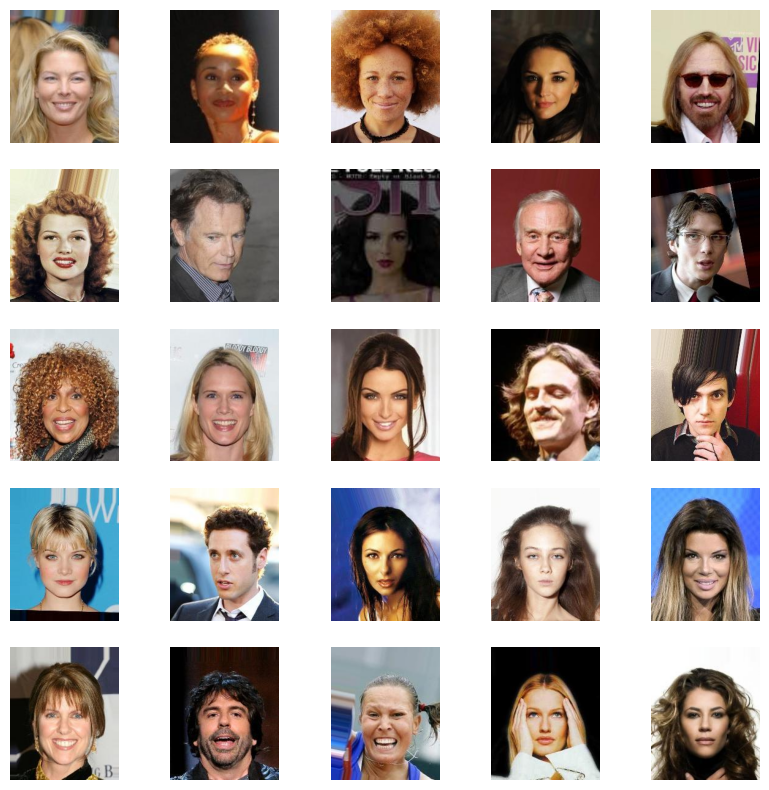

In [14]:
# subplots of 5x5 images
from matplotlib import pyplot as plt
random_indices = torch.randint(0, len(train_dataset), (25,))
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(train_dataset[random_indices[i]][0].transpose((1,2,0)))
    plt.axis('off')
plt.show()

## Set device

In [15]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] current used device: {device}")

[INFO] current used device: cuda


## Defining the model

In [16]:
# Defining model
from torch import nn
from torchvision.models import resnet18
# multi-task model
class MultiTaskClassBase(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = resnet18()
        # removing last layer (fc)
        self.resnet.fc = nn.Sequential()
    
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        x = self.resnet(x)
        return x

class MultiTaskClass(MultiTaskClassBase):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.fc = nn.Linear(512, num_classes)
    
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        x = super().forward(x)
        x = self.fc(x)
        return x
        

/home/planck/anaconda3/envs/bikash/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [17]:
# Defining loss function
class MultiTaskLoss(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()
        self.num_classes = num_classes
    
    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor)-> torch.Tensor:
        loss = 0
        factor = 1 / self.num_classes
        for i in range(self.num_classes):
            loss +=  factor * self.loss(y_pred[:,i], y_true[:,i])
        return loss

## Util Functions

### training functions

In [18]:
from torch import nn
import torch
import torchmetrics
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    profiler: torch.profiler.profile = None,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      profiler (torch.profiler.profile, optional): Pytorch Profiler. Defaults to None.
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    if profiler != None:
      profiler.start()
      for step,(X, y) in enumerate(dataloader):  # loop in batches
        if step >= (1 + 1 + 3) * 2:
          break
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        train_acc += acc_fn(y_pred_logits, y).item()
        
        profiler.step()
      profiler.stop()
    else:
      for step,(X, y) in enumerate(dataloader):  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1)
        # print(f"y_pred: {y_pred}, actual y: {y}")
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        train_acc += acc_fn(y_pred_logits, y).item()
    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)
  
  
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)
  
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    save_info: str,
    profiler:torch.profiler.profile = None,
    device: str = 'cpu',
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      save_info (str): info for saving model
      profiler (torch.profiler.profile, optional): Pytorch Profiler. Defaults to None.
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_acc = 0
    best_model_params = None

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
            profiler=profiler,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_params = model.state_dict()

    # 5. saving the best model
    if profiler == None:
      torch.save(best_model_params, f"{model.__class__.__name__}_epoch_{epochs}_optim_adam_"+save_info+".pth")
    # 6. return result dict
    return result_dict

### plotting function

In [19]:
# plot function for loss and accuracy
from typing import Dict,List
# matplot libs
import matplotlib.pyplot as plt

def plot_curves(results: Dict[str, List[float]],plot_name:str = "result"):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    plt.savefig(f'{plot_name}.png')

## Training the model

In [20]:
# function to get the model
def get_model():
    model = MultiTaskClass(num_classes=8)
    return model

current exp / total: 1 / 2
Training with: lr: 0.001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2917 | train_acc: 0.8751 | test_loss: 0.3718 | test_acc: 0.8512
Epoch: 2 | train_loss: 0.2510 | train_acc: 0.8941 | test_loss: 0.3118 | test_acc: 0.8647
Epoch: 3 | train_loss: 0.2410 | train_acc: 0.8985 | test_loss: 0.2825 | test_acc: 0.8799
Epoch: 4 | train_loss: 0.2362 | train_acc: 0.9003 | test_loss: 0.2523 | test_acc: 0.8926
Epoch: 5 | train_loss: 0.2335 | train_acc: 0.9017 | test_loss: 0.3474 | test_acc: 0.8548
Epoch: 6 | train_loss: 0.2321 | train_acc: 0.9022 | test_loss: 0.2758 | test_acc: 0.8823
Epoch: 7 | train_loss: 0.2307 | train_acc: 0.9028 | test_loss: 0.3866 | test_acc: 0.8371
Epoch: 8 | train_loss: 0.2294 | train_acc: 0.9034 | test_loss: 0.2584 | test_acc: 0.8920
Epoch: 9 | train_loss: 0.2283 | train_acc: 0.9034 | test_loss: 0.2604 | test_acc: 0.8894
Epoch: 10 | train_loss: 0.2273 | train_acc: 0.9039 | test_loss: 0.2649 | test_acc: 0.8853
Epoch: 11 | train_loss: 0.2266 | train_acc: 0.9042 | test_loss: 0.2773 | test_acc: 0.8793
Epoch: 12 | train_l

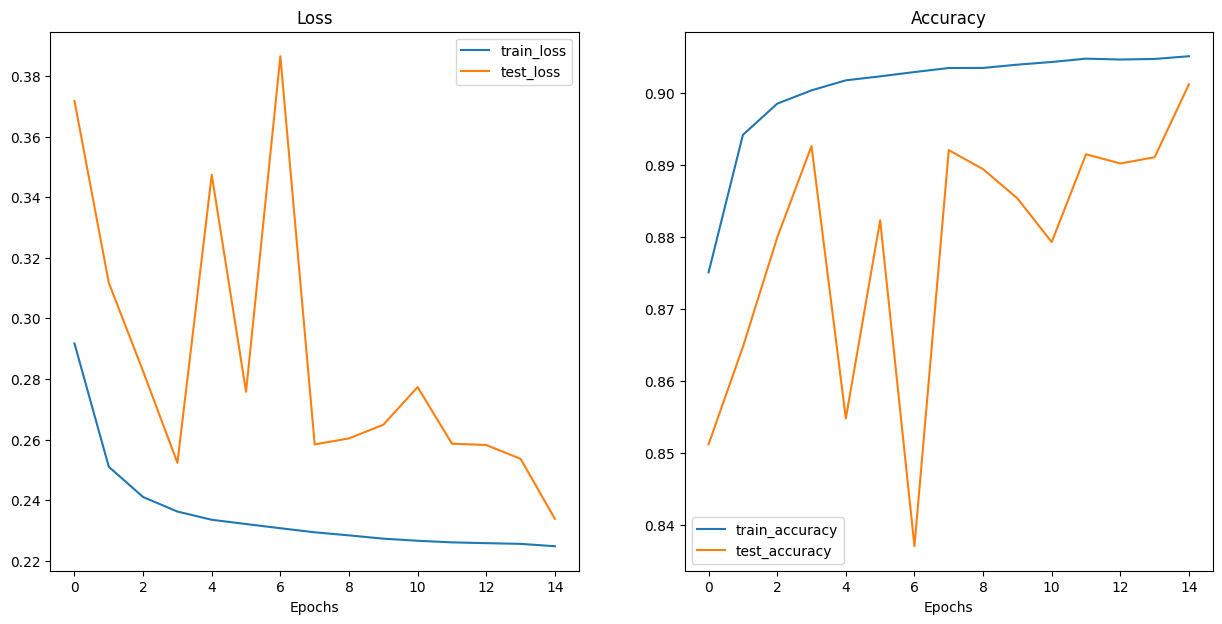


current exp / total: 2 / 2
Training with: lr: 0.0001, betas: (0.8, 0.888), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2743 | train_acc: 0.8812 | test_loss: 0.2690 | test_acc: 0.8851
Epoch: 2 | train_loss: 0.2290 | train_acc: 0.9015 | test_loss: 0.2364 | test_acc: 0.8990
Epoch: 3 | train_loss: 0.2166 | train_acc: 0.9069 | test_loss: 0.2319 | test_acc: 0.8999
Epoch: 4 | train_loss: 0.2091 | train_acc: 0.9104 | test_loss: 0.2363 | test_acc: 0.8984
Epoch: 5 | train_loss: 0.2026 | train_acc: 0.9136 | test_loss: 0.2209 | test_acc: 0.9064
Epoch: 6 | train_loss: 0.1977 | train_acc: 0.9160 | test_loss: 0.2314 | test_acc: 0.9020
Epoch: 7 | train_loss: 0.1923 | train_acc: 0.9187 | test_loss: 0.2446 | test_acc: 0.8914
Epoch: 8 | train_loss: 0.1858 | train_acc: 0.9219 | test_loss: 0.2197 | test_acc: 0.9060
Epoch: 9 | train_loss: 0.1787 | train_acc: 0.9254 | test_loss: 0.2373 | test_acc: 0.8995
Epoch: 10 | train_loss: 0.1706 | train_acc: 0.9294 | test_loss: 0.2243 | test_acc: 0.9042
Epoch: 11 | train_loss: 0.1626 | train_acc: 0.9328 | test_loss: 0.2267 | test_acc: 0.9055
Epoch: 12 | train_l

<Figure size 640x480 with 0 Axes>

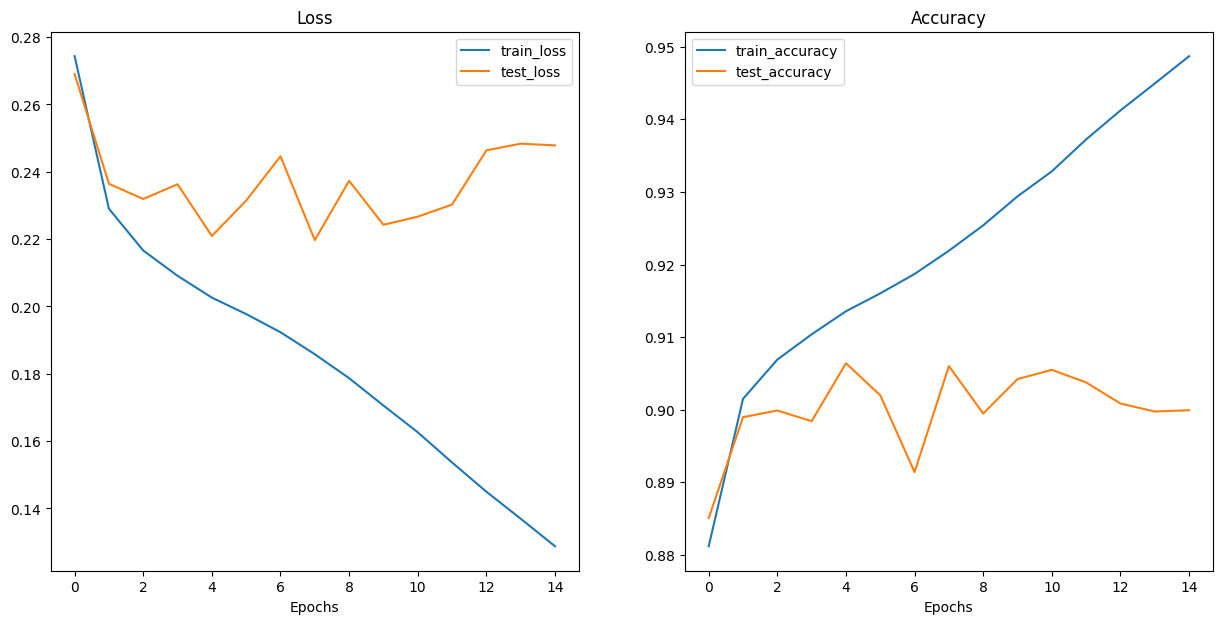

<Figure size 640x480 with 0 Axes>

In [58]:
from timeit import default_timer as timer
from torchmetrics import Accuracy

# Hyperparms
lr = [1e-3,1e-4] # learning rate
betas=[(0.8, 0.888)] # coefficients used for computing running averages of gradient and its square
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)

# init. epochs
NUM_EPOCHS = [15]

parms_combs = [(l,b,e,w_d,epochs) for l in lr for b in betas for e in eps for w_d in weight_decay for epochs in NUM_EPOCHS]

# init. loss function, accuracy function and optimizer
loss_fn = MultiTaskLoss(num_classes=8).to(device=device)
acc_fn = Accuracy(task="binary").to(device=device)

cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)*len(NUM_EPOCHS)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model = get_model().to(device=device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  
  model_results = train(
      model=model,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=h_parms[4],
      save_info=f"lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}",
      device=device
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_curves(model_results,f"{model.__class__.__name__}_epoch_{h_parms[4]}_optim_adam_"
              +
              f"lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}")
  cur+=1
  print()

In [21]:
# calculating task wise accuracy
def task_wise_accuracy(model, test_dataloader, device):
    for task in range(8):
        task_acc = 0
        task_count = 0
        for batch in test_dataloader:
            x = batch[0].to(device=device)
            y = batch[1].to(device=device)
            y = y[:,task]
            y = y.unsqueeze(1)
            y = y.type(torch.float32)
            # print(y.shape)
            # print(y)
            y_pred = model(x)
            y_pred = y_pred[:,task]
            y_pred = y_pred.unsqueeze(1)
            y_pred = y_pred.type(torch.float32)
            # print(y_pred.shape)
            # print(y_pred)
            # print(y_pred.shape)
            # print(y.shape)
            acc = acc_fn(y_pred,y)
            task_acc += acc
            task_count += 1
        print(f"task {task} accuracy: {task_acc/task_count:.4f}")

In [22]:
# loading the best model
model = get_model().to(device=device)
model.load_state_dict(torch.load("MultiTaskClass_epoch_15_optim_adam_lr_0.001_betas_(0.8, 0.888)_eps_1e-08_weight_decay_0.001.pth"))
model.eval()

MultiTaskClass(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [25]:
# printing task wise accuracy
from torchmetrics import Accuracy
acc_fn = Accuracy(task="binary").to(device=device)
task_wise_accuracy(model, test_dataloader, device)

task 0 accuracy: 0.9136
task 1 accuracy: 0.8182
task 2 accuracy: 0.8333
task 3 accuracy: 0.8943
task 4 accuracy: 0.9857
task 5 accuracy: 0.9258
task 6 accuracy: 0.8785
task 7 accuracy: 0.9639


In [26]:
# print task labels
print(f"Task labels: {df.columns[-9:-1]}")

Task labels: Index(['Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie'],
      dtype='object')
